In [2]:
from glob import glob 
import numpy as np 

all_paths = glob('/kaggle/input/breast-histopathology-images/*/*/*.png')
np.random.shuffle(all_paths)

val_size = 0.1 
test_size = 0.2 

num_train = int(len(all_paths)*(1-test_size)) 
num_test = int(len(all_paths)*test_size)
num_validation = int(num_train*val_size)

train_paths_cur = all_paths[:num_train]
test_paths_cur = all_paths[num_train:]
val_paths_cur, train_paths_cur = train_paths_cur[:num_validation], train_paths_cur[num_validation:]

print('Number images {}-{}-{} corresponding training data, validation data, test data.'.format(num_train, num_validation, num_test))

Number images 222019-22201-55504 corresponding training data, validation data, test data.


In [4]:
import os 
BASE_PATH = 'datasets'
TRAIN_PATH = os.path.sep.join([BASE_PATH, 'training'])
VAL_PATH = os.path.sep.join([BASE_PATH, 'validation'])
TEST_PATH = os.path.sep.join([BASE_PATH, 'testing'])

In [6]:
from tqdm import tqdm
import shutil

datasets = [('training', train_paths_cur, TRAIN_PATH),
           ('validation', val_paths_cur, VAL_PATH),
            ('testing', test_paths_cur, TEST_PATH)
           ]

if hasattr(tqdm, '_instances'): tqdm._instances.clear()
    
for (setType, originalPaths, basePath) in datasets:
    print("Build {} set.".format(setType))
    if not os.path.exists(basePath):
        print(f"Buiding {basePath} directory.")
        os.makedirs(basePath)
    for path in tqdm(originalPaths):
        filename = path.split('/')[-1]
        label = filename[-5:-4]
        newpath = os.path.join(basePath, label)
        if not os.path.exists(newpath):
            print(f"Buiding {newpath} directory.")
            os.makedirs(newpath)
        shutil.copy2(path, newpath)

  0%|          | 32/199818 [00:00<10:25, 319.53it/s]

Build training set.
Buiding datasets/training/0 directory.
Buiding datasets/training/1 directory.


  0%|          | 42/22201 [00:00<00:53, 415.28it/s]

Build validation set.
Buiding datasets/validation directory.
Buiding datasets/validation/0 directory.
Buiding datasets/validation/1 directory.


  0%|          | 43/55505 [00:00<02:09, 429.91it/s]

Build testing set.
Buiding datasets/testing directory.
Buiding datasets/testing/0 directory.
Buiding datasets/testing/1 directory.


100%|██████████| 55505/55505 [02:28<00:00, 373.23it/s]


In [20]:
from keras.preprocessing.image import ImageDataGenerator 

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/kaggle/working/datasets/training',
        target_size=(50, 50),
        batch_size=64,
        class_mode='binary')

validation_generator = train_datagen.flow_from_directory(
        '/kaggle/working/datasets/validation',
        target_size=(50, 50),
        batch_size=64,
        class_mode='binary')

Found 199818 images belonging to 2 classes.
Found 22201 images belonging to 2 classes.


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout, Dense

def build_model(width, height, depth):
    shape = (height, width, depth)
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2))
    
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2))
    
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

model = build_model(50, 50, 3)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 50, 50, 32)        896       
_________________________________________________________________
batch_normalization_9 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 25, 25, 64)        18496     
_________________________________________________________________
batch_normalization_10 (Batc (None, 25, 25, 64)        256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 256)      

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint

model.optimizer.learning_rate = 5e-3
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True, verbose=0)
history = model.fit_generator(train_generator, validation_data=validation_generator, 
                    epochs=10, callbacks=[checkpoint], verbose=1)

Train for 3123 steps, validate for 347 steps
Epoch 1/10
3123/3123 [==============================] - 255s 82ms/step - loss: 0.3947 - accuracy: 0.8444 - val_loss: 0.8144 - val_accuracy: 0.7876
Epoch 2/10
3123/3123 [==============================] - 253s 81ms/step - loss: 0.3330 - accuracy: 0.8587 - val_loss: 0.5099 - val_accuracy: 0.8395
Epoch 3/10
3123/3123 [==============================] - 254s 81ms/step - loss: 0.3203 - accuracy: 0.8659 - val_loss: 15.7587 - val_accuracy: 0.4160
Epoch 4/10
3123/3123 [==============================] - 254s 81ms/step - loss: 0.3116 - accuracy: 0.8688 - val_loss: 0.4828 - val_accuracy: 0.8160
Epoch 5/10
3123/3123 [==============================] - 255s 82ms/step - loss: 0.3066 - accuracy: 0.8721 - val_loss: 1.1648 - val_accuracy: 0.7870
Epoch 6/10
3123/3123 [==============================] - 253s 81ms/step - loss: 0.3001 - accuracy: 0.8744 - val_loss: 0.3136 - val_accuracy: 0.8661
Epoch 7/10
3123/3123 [==============================] - 253s 81ms/step -

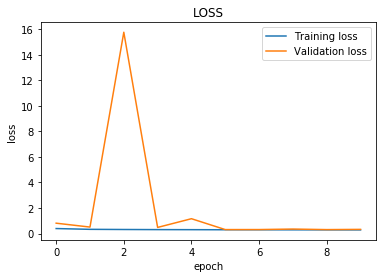

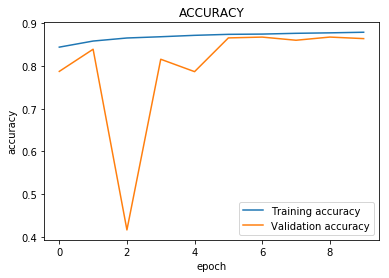

In [29]:
import matplotlib.pyplot as plt 
%matplotlib inline 

plt.figure(0)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('LOSS')
plt.legend()

plt.figure(1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('ACCURACY')
plt.legend()

In [25]:
test_generator = test_datagen.flow_from_directory(
        '/kaggle/working/datasets/testing',
        target_size=(50, 50),
        batch_size=64,
        class_mode='binary')

from tensorflow.keras.models import load_model
model = load_model('model.h5')
model.evaluate_generator(test_generator)

[0.32249498035123547, 0.86509323]